## Neural Network Regression

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from keras.constraints import maxnorm

In [2]:
rate_df = pd.read_csv('../../data/rates_clean.csv', engine = 'python')

rate_df['neighbourhood_group_cleansed'] = rate_df['neighbourhood_group_cleansed'].astype('category')
rate_df['neighbourhood_cleansed'] = rate_df['neighbourhood_cleansed'].astype('category')
rate_df['property_type'] = rate_df['property_type'].astype('category')
rate_df['room_type'] = rate_df['room_type'].astype('category')
rate_df['bedrooms'] = rate_df['bedrooms'].astype('category')
rate_df['bathrooms'] = rate_df['bathrooms'].astype('category')

rate_df.head()

,neighbourhood_group_cleansed,neighbourhood_cleansed,property_type,room_type,bedrooms,bathrooms,guests_included,price,lnprice
0,Manhattan,Midtown,Apartment,Entire home/apt,0,1.0,1,225,5.416100
1,Brooklyn,Clinton Hill,Guest suite,Entire home/apt,1,1.0,1,89,4.488636
2,Manhattan,Murray Hill,Apartment,Entire home/apt,1,1.0,2,200,5.298317
3,Manhattan,Hell's Kitchen,Apartment,Private room,1,1.0,1,79,4.369448
4,Manhattan,Upper West Side,Apartment,Private room,1,1.0,1,79,4.369448


In [3]:
full_df = rate_df

full_ddf = pd.get_dummies(full_df['neighbourhood_group_cleansed'], drop_first = True, prefix = 'borough:')
full_ddf = pd.concat([full_ddf, pd.get_dummies(full_df['neighbourhood_cleansed'], drop_first = True, prefix = 'hood:')], 
                     axis = 1)
full_ddf = pd.concat([full_ddf, pd.get_dummies(full_df['property_type'], drop_first = True, prefix = 'property:')], 
                     axis = 1)
full_ddf = pd.concat([full_ddf, pd.get_dummies(full_df['room_type'],  prefix = 'room:')], axis = 1)
full_ddf = pd.concat([full_ddf, pd.get_dummies(full_df['bedrooms'],  prefix = 'bed:')], axis = 1)
full_ddf = pd.concat([full_ddf, pd.get_dummies(full_df['bathrooms'],  prefix = 'bath:')], axis = 1)

full_df = full_df.drop(['neighbourhood_group_cleansed', 'neighbourhood_cleansed', 'property_type', 
                        'room_type', 'bedrooms', 'bathrooms', 'price'], axis = 1)

y = pd.DataFrame(full_df['lnprice']).reset_index(drop = True)

full_df = full_df.drop('lnprice', axis = 1)

def featureNormalize(X):
    return (X - np.mean(X, axis = 0)) / np.std(X, axis = 0, ddof = 1)

X = pd.concat([featureNormalize(full_df), full_ddf], axis = 1).reset_index(drop = True)

In [4]:
random.seed(42)
X_train = X.sample(frac = 0.7).sort_index()
y_train = y[X.index.isin(X_train.index)]
X_test = X[~X.index.isin(X_train.index)]
y_test = y[~X.index.isin(X_train.index)]

In [5]:
def create_model1(neurons = 0):
    model = Sequential()
    model.add(Input(shape = (234, )))
    model.add(Dense(neurons, kernel_initializer = 'normal', activation = 'relu'))
    model.add(Dense(1, kernel_initializer = 'normal'))
    model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['MeanSquaredError'])
    return model

#### Model 1: # of Neurons in the 1st hidden layer

In [6]:
nnc1_model = KerasRegressor(build_fn = create_model1, batch_size = 100, epochs = 10, verbose = 0)

nnc1_neuron_arr = [1, 5, 10, 15, 20, 25, 30]

nnc1 = GridSearchCV(estimator = nnc1_model, 
                    param_grid = {'neurons' : nnc1_neuron_arr}, 
                    n_jobs = -1, scoring = 'neg_root_mean_squared_error', cv = 5, return_train_score = True)

nnc1.fit(X_train.values, y_train)

nnc1_df = pd.DataFrame(nnc1.cv_results_)

In [7]:
nnc1_df[['param_neurons', 'mean_train_score', 'mean_test_score']]

,param_neurons,mean_train_score,mean_test_score
0,1,-0.789161,-0.817513
1,5,-0.388352,-0.396075
2,10,-0.386266,-0.394673
3,15,-0.382980,-0.392163
4,20,-0.379034,-0.389621
5,25,-0.381807,-0.391318
6,30,-0.378872,-0.391520


#### Model 2: # of Neurons in the 2nd hidden layer

In [8]:
def create_model2(neurons = 0):
    model = Sequential()
    model.add(Input(shape = (234, )))
    model.add(Dense(10, kernel_initializer = 'normal', activation = 'relu'))
    model.add(Dense(neurons, kernel_initializer = 'normal', activation = 'relu'))
    model.add(Dense(1, kernel_initializer = 'normal'))
    model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['MeanSquaredError'])
    return model

In [9]:
nnc2_model = KerasRegressor(build_fn = create_model2, batch_size = 100, epochs = 10, verbose = 0)

nnc2_neuron_arr = [1, 5, 10, 15, 20, 25, 30]

nnc2 = GridSearchCV(estimator = nnc2_model, 
                    param_grid = {'neurons' : nnc2_neuron_arr}, 
                    n_jobs = -1, scoring = 'neg_root_mean_squared_error', cv = 5, return_train_score = True)

nnc2.fit(X_train.values, y_train)

nnc2_df = pd.DataFrame(nnc2.cv_results_)

In [10]:
nnc2_df[['param_neurons', 'mean_train_score', 'mean_test_score']]

,param_neurons,mean_train_score,mean_test_score
0,1,-1.182591,-1.178889
1,5,-0.382897,-0.391716
2,10,-0.385259,-0.395022
3,15,-0.383490,-0.392320
4,20,-0.386276,-0.395449
5,25,-0.383805,-0.393770
6,30,-0.387187,-0.394925


#### Model 3: # of Neurons in the 3rd hidden layer

In [11]:
def create_model3(neurons = 0):
    model = Sequential()
    model.add(Input(shape = (234, )))
    model.add(Dense(10, kernel_initializer = 'normal', activation = 'relu'))
    model.add(Dense(5, kernel_initializer = 'normal', activation = 'relu'))
    model.add(Dense(neurons, kernel_initializer = 'normal', activation = 'relu'))
    model.add(Dense(1, kernel_initializer = 'normal'))
    model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['MeanSquaredError'])
    return model

In [12]:
nnc3_model = KerasRegressor(build_fn = create_model3, batch_size = 100, epochs = 10, verbose = 0)

nnc3_neuron_arr = [1, 5, 10, 15, 20, 25, 30]

nnc3 = GridSearchCV(estimator = nnc3_model, 
                    param_grid = {'neurons' : nnc3_neuron_arr}, 
                    n_jobs = -1, scoring = 'neg_root_mean_squared_error', cv = 5, return_train_score = True)

nnc3.fit(X_train.values, y_train)

nnc3_df = pd.DataFrame(nnc3.cv_results_)

In [13]:
nnc3_df[['param_neurons', 'mean_train_score', 'mean_test_score']]

,param_neurons,mean_train_score,mean_test_score
0,1,-1.575901,-1.588166
1,5,-0.385305,-0.393800
2,10,-0.383543,-0.391709
3,15,-0.384742,-0.393099
4,20,-0.383219,-0.391470
5,25,-0.381561,-0.390569
6,30,-0.383004,-0.393495


#### Model 4: Learning Rate of the Network

In [14]:
def create_model4(learn_rate = 0.01):
    model = Sequential()
    model.add(Input(shape = (234, )))
    model.add(Dense(10, kernel_initializer = 'normal', activation = 'relu'))
    model.add(Dense(5, kernel_initializer = 'normal', activation = 'relu'))
    model.add(Dense(1, kernel_initializer = 'normal'))
    optimizer = Adam(learning_rate = learn_rate)
    model.compile(loss = 'mean_squared_error', optimizer = optimizer, metrics = ['MeanSquaredError'])
    return model

In [15]:
nnc4_model = KerasRegressor(build_fn = create_model4, batch_size = 100, epochs = 10, verbose = 0)

nnc4_learn_rate_arr = [0.001, 0.01, 0.1, 0.2, 0.5]

nnc4 = GridSearchCV(estimator = nnc4_model, 
                    param_grid = {'learn_rate' : nnc4_learn_rate_arr}, 
                    n_jobs = -1, scoring = 'neg_root_mean_squared_error', cv = 5, return_train_score = True)

nnc4.fit(X_train.values, y_train)

nnc4_df = pd.DataFrame(nnc4.cv_results_)

In [16]:
nnc4_df[['param_learn_rate', 'mean_train_score', 'mean_test_score']]

,param_learn_rate,mean_train_score,mean_test_score
0,0.001,-0.385073,-0.393877
1,0.01,-0.385087,-0.396643
2,0.1,-0.383091,-0.396959
3,0.2,-0.391085,-0.402910
4,0.5,-0.643989,-0.649535


#### Model 5: Drop-out Rate and Weight Constraint of the Network

In [17]:
def create_model5(dropout_rate = 0.0, weight_constraint = 0):
    model = Sequential()
    model.add(Input(shape = (234, )))
    model.add(Dense(10, kernel_initializer = 'normal', kernel_constraint = maxnorm(weight_constraint), activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(5, kernel_initializer = 'normal', kernel_constraint = maxnorm(weight_constraint), activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, kernel_initializer = 'normal'))
    optimizer = Adam(learning_rate = 0.1)
    model.compile(loss = 'mean_squared_error', optimizer = optimizer, metrics = ['MeanSquaredError'])
    return model

In [18]:
nnc5_model = KerasRegressor(build_fn = create_model5, batch_size = 100, epochs = 10, verbose = 0)

nnc5_wgt_constraint_arr = [0, 1, 2, 3, 4, 5]
nnc5_dropout_rate_arr = [0.0, 0.1, 0.2, 0.5, 0.9]

nnc5 = GridSearchCV(estimator = nnc5_model, 
                    param_grid = {'weight_constraint' : nnc5_wgt_constraint_arr,
                                  'dropout_rate' : nnc5_dropout_rate_arr}, 
                    n_jobs = -1, scoring = 'neg_root_mean_squared_error', cv = 5, return_train_score = True)

nnc5.fit(X_train.values, y_train)

nnc5_df = pd.DataFrame(nnc5.cv_results_)

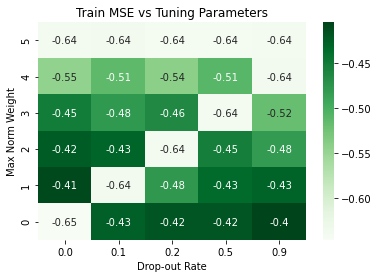

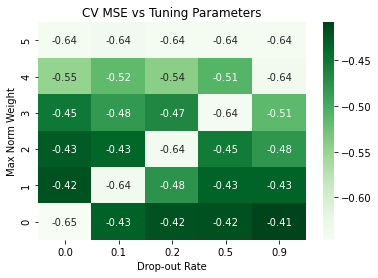

In [19]:
nnc5_train_rmse_mat = nnc5_df['mean_train_score'].values.reshape(len(nnc5_wgt_constraint_arr), len(nnc5_dropout_rate_arr))
ax = sns.heatmap(pd.DataFrame(nnc5_train_rmse_mat, columns = nnc5_dropout_rate_arr, 
                              index = nnc5_wgt_constraint_arr).iloc[::-1], annot = True, cmap = 'Greens')
ax.set(xlabel = 'Drop-out Rate', ylabel = 'Max Norm Weight', title = 'Train MSE vs Tuning Parameters')
plt.show()

nnc5_cv_rmse_mat = nnc5_df['mean_test_score'].values.reshape(len(nnc5_wgt_constraint_arr), len(nnc5_dropout_rate_arr))
ax = sns.heatmap(pd.DataFrame(nnc5_cv_rmse_mat, columns = nnc5_dropout_rate_arr, 
                              index = nnc5_wgt_constraint_arr).iloc[::-1], annot = True, cmap = 'Greens')
ax.set(xlabel = 'Drop-out Rate', ylabel = 'Max Norm Weight', title = 'CV MSE vs Tuning Parameters')
plt.show()

#### Final Model

In [20]:
def final_model():
    model = Sequential()
    model.add(Input(shape = (234, )))
    model.add(Dense(10, kernel_initializer = 'normal', activation = 'relu'))
    model.add(Dense(5, kernel_initializer = 'normal', activation = 'relu'))
    model.add(Dense(1, kernel_initializer = 'normal'))
    optimizer = Adam(learning_rate = 0.1)
    model.compile(loss = 'mean_squared_error', optimizer = optimizer, metrics = ['MeanSquaredError'])
    return model

annr = KerasRegressor(build_fn = final_model, batch_size = 100, epochs = 10, verbose = 0)

annr.fit(X_train.values, y_train)

In [21]:
pred_annr = annr.predict(X_test)

print('Test RMSE: {:.4f}'.format(mean_squared_error(y_test, pred_annr, squared = False)))
print('Test MAE: {:.4f}'.format(mean_absolute_error(y_test, pred_annr)))
print('Test R2: {:.4f}'.format(r2_score(y_test, pred_annr)))

Test RMSE: 0.3890
Test MAE: 0.2969
Test R2: 0.6327
